<a href="https://colab.research.google.com/github/CesarCasasola/MachineLearningPython/blob/main/regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Productividad de trabajadores de confeccion
## Red Neuronal

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#configurando la impresion de numeros de punto flotante a aun max de 3 digitos despues del punto
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [ ]:
original_data_set = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00597/garments_worker_productivity.csv')
original_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [ ]:
#Se descarta la primer DataSeries que contiene la fecha
original_data_set = original_data_set.drop('date', axis=1)
original_data_set.head()

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [ ]:
original_data_set.isna().sum()

quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

#### Limpieza de los datos

In [ ]:
#Dado que el atributo wip es el unico con valores faltantes y hace referencia a work in progress, el numero de items sin terminar para los productos,
#se elige como tecnica de imputacion, el reemplazo por el valor 0
original_data_set['wip'] = original_data_set['wip'].fillna(0)
original_data_set.isna().sum()
original_data_set.head()

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [ ]:
print(original_data_set['quarter'].unique())
print(original_data_set['department'].unique())
print(original_data_set['day'].unique())

['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']
['sweing' 'finishing ' 'finishing']
['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
original_data_set[['quarter', 'department', 'day']] = encoder.fit_transform(original_data_set[['quarter', 'department', 'day']])

In [ ]:
original_data_set.describe().T

,count,mean,std,min,25%,50%,75%,max
quarter,1197.0,1.399332,1.215535,0.000000,0.000000,1.000000,2.000000,4.000000
department,1197.0,1.369256,0.805909,0.000000,1.000000,2.000000,2.000000,2.000000
day,1197.0,2.534670,1.714538,0.000000,1.000000,3.000000,4.000000,5.000000
team,1197.0,6.426901,3.463963,1.000000,3.000000,6.000000,9.000000,12.000000
targeted_productivity,1197.0,0.729632,0.097891,0.070000,0.700000,0.750000,0.800000,0.800000
smv,1197.0,15.062172,10.943219,2.900000,3.940000,15.260000,24.260000,54.560000
wip,1197.0,687.228070,1514.582341,0.000000,0.000000,586.000000,1083.000000,23122.000000
over_time,1197.0,4567.460317,3348.823563,0.000000,1440.000000,3960.000000,6960.000000,25920.000000
incentive,1197.0,38.210526,160.182643,0.000000,0.000000,0.000000,50.000000,3600.000000
idle_time,1197.0,0.730159,12.709757,0.000000,0.000000,0.000000,0.000000,300.000000


In [ ]:
#Separando los datos en grupos de entrenamiento y validacion
X = original_data_set.iloc[:, 0:12]
y = original_data_set['actual_productivity']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

[[   1.393    1.376    2.543    6.456    0.73    15.047  704.405 4635.037
    36.251    0.586    0.361    0.141]]


### Definiendo un modelo con DNN

In [ ]:
import keras.backend as K
def soft_acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [ ]:
dnn_model = keras.Sequential([
                 normalizer,
                 layers.Dense(64, activation='relu'),
                 layers.Dense(64, activation='relu'),
                 layers.Dense(1)             
])

dnn_model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=[soft_acc])

dnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 12)               25        
 n)                                                              
                                                                 
 dense_13 (Dense)            (None, 64)                832       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,082
Trainable params: 5,057
Non-trainable params: 25
_________________________________________________________________


In [ ]:
history = dnn_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=0, epochs=100)


In [ ]:
dnn_test_results = dnn_model.evaluate(X_test, y_test)
print("Error absoluto promedio: ", dnn_test_results[0])
print("Accuracy: ", dnn_test_results[1])

8/8 [==============================] - 0s 2ms/step - loss: 0.1002 - soft_acc: 0.8906
Error absoluto promedio:  0.10022062808275223
Accuracy:  0.890625


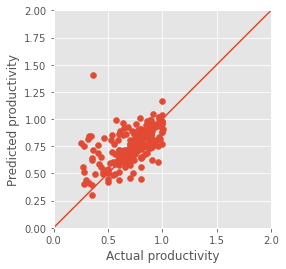

In [ ]:
y_pred = dnn_model.predict(X_test).flatten()
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('Actual productivity')
plt.ylabel('Predicted productivity')
lims = [0, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)



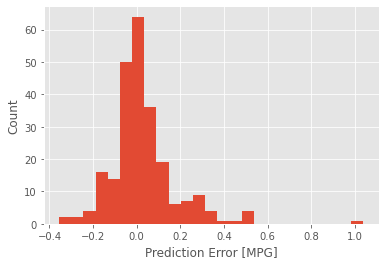

In [62]:
error = y_pred - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')
